<h1>Assignment 3</h1>

<h2>Due: Tue 28 Jan 2020 Midnight</h2>
<a href='http://www.cs.bgu.ac.il/~elhadad/nlp21.html'>Natural Language Processing - Fall 2021 Michael Elhadad</a>
<p/>
This assignment covers the topic of syntactic parsing.
Submit your solution in the form of a Jupyter notebook (ipynb) file.

<h2>Content</h2>
<ul>
<li><a href="#q1">Q1: Designing CFGs for NLP</a></li>
    <ul>
        <li><a href="#q1.1">Q1.1: Extend a CFG to support Number agreement, Pronouns and Dative Constructions</a>
            <ul>
                <li><a href="#q1.1.1">Q1.1.1 Determiners and Count/Mass Nouns</a></li>
                <li><a href="#q1.1.2">Q1.1.2 Pronouns</a></li>
                <li><a href="#q1.1.3">Q1.1.3 Subject/Verb Agreement</a></li>
                <li><a href="#q1.1.4">Q1.1.4 Over-generation</a></li>
            </ul>            
        </li>
        <li><a href="#q1.2">Q1.2: Extend a CFG to support Coordination and Prepositional Phrases</a>
            <ul>
                <li><a href="#q1.2.1">Q1.2.1 Support Prepositional Phrases</a></li>
                <li><a href="#q1.2.2">Q1.2.2 Support Coordination</a></li>
                <li><a href="#q1.2.3">Q1.2.3 Over-generation</a></li>
            </ul>            
        </li>
    </ul>
</li>
<li><a href="#q2">Q2: Learning a PCFG from a Treebank</a>
    <ul>
        <li><a href="#q2.1">Q2.1 Random PCFG Generation</a>
            <ul>
                <li><a href="#q2.1.1">Q2.1.1 PCFG_Generate</a></li>
                <li><a href="#q2.1.2">Q2.1.2 Generate 1,000 Trees</a></li>
                <li><a href="#q2.1.3">Q2.1.3 Gather Rules Frequency for all Non-Terminals</a></li>
                <li><a href="#q2.1.4">Q2.1.4 Compute KL-Divergence between a priori and generated parameters</a></li>
            </ul>
        </li>
        <li><a href="#q2.2">Q2.2 Learn a PCFG from a Treebank</a>
            <ul>
                <li><a href="#q2.2.1">Q2.2.1 Induce_PCFG</a></li>
                <li><a href="#q2.2.2">Q2.2.2 Data Exploration</a></li>
            </ul>
        </li>
        <li><a href="#q2.3">Q2.3 Induce a PCFG in Chomsky Normal Form</a>
            <ul>
                <li><a href="#q2.3.1">Q2.3.1 PCFG_CNF_Learn</a></li>
                <li><a href="#q2.3.2">Q2.3.2 Data Exploration</a></li>
            </ul>
        </li>
        <li><a href="#q2.4">Q2.4 Test CFG Independence Assumptions</a></li>
    </ul>
</li>
<li><a href="#q3">Q3: Building and Evaluating a Simple PCFG Parser</a>
	<ul>
        <li><a href="#q3.1">Q3.1 Build a Parser</a>
            <ul>
                <li><a href="#q3.1.1">Q3.1.1 Dataset Split</a></li>
                <li><a href="#q3.1.2">Q3.1.2 Learn a PCFG over the Chomsky Normal Form</a></li>
                <li><a href="#q3.1.3">Q3.1.3 Viterbi Parser</a></li>
            </ul>            
        </li>
        <li><a href="#q3.2">Q3.2 Evaluate the Parser</a></li>
        <li><a href="#q3.3">Q3.3 Accuracy per Distance</a></li>
        <li><a href="#q3.4">Q3.4 Accuracy per Label</a></li>
    </ul>
</li>
</ul>

<hr/>
<a name="q1"></a>
<h2>Question 1: Designing CFGs for NLP</h2>

NLTK provides library support to read CFGs from string representation, and parse sentences given a CFG using different 
parsing algorithms (either top-down or bottom-up).  In this question, we manually develop a grammar to support 
increasingly complex phenomena in English syntax. The following code provides the starting point:

In [ ]:
import nltk
from nltk import CFG
from nltk import ViterbiParser
sg = """
S -> NP VP
VP -> IV | TV NP
NP -> 'John' | "bread"
IV -> 'left'
TV -> 'eats'
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = sent.split()
    trees = sr_parser.parse(tokens)
    found = False
    for tree in  trees:
      if tree.label() == 'S':
        found = True
    print(f'sent {sent} :: {found}')
parse_sentence("John left")
parse_sentence("John eats bread")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
sent John left :: True
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV * bread]
  S [ NP TV 'bread' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
sent John eats bread :: True


In this toy grammar, the following non-terminals are used:
<ul>
<li>S: sentence
<li>VP: verb phrase
<li>NP: noun phrase
<li>IV: intransitive verb (a verb which does not expect a complement)
<li>TV: transitive verb (a verb which expects an obligatory complement)
</ul>

<a name="q1.1"></a>
<h3>Question 1.1: Extend a CFG to support Determiners, Number agreement, Countable/Mass nouns, Pronouns and Dative Constructions</h3>

Extend the CFG so that the following sentences can be parsed:
<pre>
    John left
    John loves Mary
    They love Mary
    They love her
    She loves them
    Everybody loves John
    A boy loves Mary
	The boy loves Mary
	Some boys love Mary
    John gave Mary a heavy book
    John gave it to Mary
	John likes butter
	John moves a chair
</pre>

<a name="q1.1.1"></a>
<h4>1.1.1 Determiners and Count/Mass Nouns</h4>

<b>Determiners</b> in English come before common nouns.
Proper nouns cannot have a determiner. (We ignore cases such as "The Petersons came by tonight for a visit.")
<p/>
Some determiners can only be used for singular nouns ("a"), others only for plural nouns ("many") and others with either plural or singular ("the").
<p/>
Some common nouns are called "uncountable" or <a href="https://en.wikipedia.org/wiki/Mass_noun">mass nouns</a> (e.g., "butter").
Mass nouns cannot appear in plural and cannot have counting determiners.
Other nouns are <a href=https://en.wikipedia.org/wiki/Count_noun">countable nouns</a>. They can be used in the plural and can be modified by counting determiners.
<p/>
Extend the grammar to support countable and uncountable nouns with the corresponding restrictions on determiners and plural.
<p/>

In [ ]:
# DET -> PD | SD | AD
shortcuts = """
PD -> plural Determiner
SD -> Singular Determiner
AD -> Agnostic Determiner
MN -> Mass Noun
CNP -> Plural Count Noun 
CNS -> Singular Count Noun
"""
sg = """
S -> NP VP
VP -> IV | TV NP
PD -> 'many'
SD -> 'a'
AD -> 'the'
MN -> 'bread' | 'butter' | 'cheese'
CNP -> 'chairs' | 'books' | 'shelfs'
CNS -> 'chair' | 'book' | 'shelf'
NP -> AD CNP | PD CNP | AD CNS | SD CNS | AD MN | PROPN | Noun
Noun -> MN | CNP | CNS
PROPN -> 'John' | 'Baraa' | 'Gabriela'
IV -> 'left'
TV -> 'looks' | 'eats' | 'reads'
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=0)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = sent.split()
    trees = sr_parser.parse(tokens)
    found = False
    for tree in  trees:
      if tree.label() == 'S':
        found = True
    print(f'{sent} ::: {found}')

parse_sentence("John left")
parse_sentence("John eats bread")
parse_sentence("John eats the bread")
parse_sentence("John eats many bread")
parse_sentence("John eats a bread")
parse_sentence("John reads the books")
parse_sentence("John reads many books")
parse_sentence("John reads a book")
parse_sentence("John reads many book")




John left ::: True
John eats bread ::: True
John eats the bread ::: True
John eats many bread ::: False
John eats a bread ::: False
John reads the books ::: True
John reads many books ::: True
John reads a book ::: True
John reads many book ::: False


<a name="q1.1.2"></a>
<h4>1.1.2 Pronouns</h4>

<b>Pronouns</b> in English are characterized by the following morphological attributes:
<ul>
    <li>Number: singular / plural (e.g., he/they)</li>
    <li>Gender: masculine / feminine / neutral (e.g., he/she/it)</li>
    <li>Case: nominative / accusative (e.g., he/him)</li>
</ul>
Make sure the appropriate form of pronouns are used in each of the possible contexts.
Do you need to encode gender in the grammar? Explain why.
<p/>

 **Do we need to encode gender in the grammar?**

No, Because there is no gender alignment between verbs and nouns/pro-nouns, a long text may be semantically incoherent if we ignore gender enodnding in the CFG but grammatically correct.

In [ ]:
shortcuts = """
PD -> plural Determiner
SD -> Singular Determiner
AD -> Agnostic Determiner
MN -> Mass Noun
CNP -> Plural Count Noun 
CNS -> Singular Count Noun
"""
sg = """
S ->  NOMINARIVE_ACCUSATIVE_SINGLE VP_SINGLE | NP_SINGLE_NOMINATIVE VP_SINGLE | NOMINARIVE_ACCUSATIVE_PLURAL VP_PLURAL | NP_PLURAL_NOMINATIVE VP_PLURAL |NPS IV | NOMINARIVE_ACCUSATIVE_SINGLE IV | NOMINARIVE_ACCUSATIVE_PLURAL IV | NP_SINGLE_NOMINATIVE IV | NP_PLURAL_NOMINATIVE IV  
VP_SINGLE ->   TVS  ACC | TVS NOMINARIVE_ACCUSATIVE_SINGLE | TVS NOMINARIVE_ACCUSATIVE_PLURAL 
VP_PLURAL ->   TVP  ACC | TVP NOMINARIVE_ACCUSATIVE_SINGLE | TVP NOMINARIVE_ACCUSATIVE_PLURAL
PD -> 'many'
SD -> 'a'
AD -> 'the'
MASS_N -> 'bread' | 'butter' | 'cheese'
COUNT_N_PLURAL -> 'chairs' | 'books' | 'shelfs'
COUNT_N_SINGLE -> 'chair' | 'book' | 'shelf'

NP_SINGLE_NOMINATIVE -> 'he' | 'she'
NP_PLURAL_NOMINATIVE -> 'they'

ACC -> PRON_SINGLE_ACCUSATIVE | PRON_PLURAL_ACCUSATIVE
NOMINARIVE_ACCUSATIVE_SINGLE -> AD COUNT_N_SINGLE | SD COUNT_N_SINGLE | AD MASS_N | PROPN | Noun
NOMINARIVE_ACCUSATIVE_PLURAL ->  AD COUNT_N_PLURAL | PD COUNT_N_PLURAL 

PRON_SINGLE_ACCUSATIVE -> 'him' | 'her'
PRON_PLURAL_ACCUSATIVE -> 'them' 

Noun -> MASS_N | COUNT_N_PLURAL | COUNT_N_SINGLE
PROPN -> 'John' | 'Baraa' | 'Gabriela'
IV -> 'left'
TVS -> 'looks' | 'eats' | 'reads' | 'likes'
TVP -> 'look' | 'eat' | 'read'
"""

g = CFG.fromstring(sg)

# print(type(g.chomsky_normal_form()))
sr_parser = nltk.RecursiveDescentParser(g, trace=0)

print('#### Count/Mass Nouns ####\n')
parse_sentence("John left")
parse_sentence("John eats bread")
parse_sentence("John eats the bread")
parse_sentence("John eats many bread")
parse_sentence("John eats a bread")
parse_sentence("John reads the books")
parse_sentence("John reads many books")
parse_sentence("John reads a book")
parse_sentence("John reads many book")

print('\n\n#### Pro-Nouns ####\n')
parse_sentence("he reads books")
parse_sentence("they read books")
parse_sentence("they reads books")
parse_sentence("John likes her")
parse_sentence("John likes she")
parse_sentence("he likes her")
parse_sentence("him likes her")

#### Count/Mass Nouns ####

John left ::: True
John eats bread ::: True
John eats the bread ::: True
John eats many bread ::: False
John eats a bread ::: False
John reads the books ::: True
John reads many books ::: True
John reads a book ::: True
John reads many book ::: False


#### Pro-Nouns ####

he reads books ::: True
they read books ::: True
they reads books ::: False
John likes her ::: True
John likes she ::: False
he likes her ::: True
him likes her ::: False


<a name="q1.1.3"></a>
<h4>1.1.3 Subject/Verb Agreement</h4>
<p/>
Make sure subject and verb agree in number.
<p/>

<a name="q1.1.4"></a>
<h4>1.1.4 Over-generation</h4>
    
Check whether your grammar overgenerates by giving an example of ungrammatical sentence that it recognizes as grammatical.
<p/>

**We think we built the model good enough, its possible because it is so simple, we dont think it overgeneates.**

In [ ]:
parse_sentence("Baraa eat Baraa")
parse_sentence("Baraa eats Baraa")


Baraa eat Baraa ::: False
Baraa eats Baraa ::: True


<a name="q1.2"></a>
<h3>Question 1.2: Extend a CFG to support Coordination and Prepositional Phrases</h3>

<a name="q1.2.1"></a>
<h4>1.2.1 Support Prepositional Phrases</h4>

Extend the grammar so that it can parse the following sentences:

<pre>
John saw a man with a telescope
John saw a man on the hill with a telescope

Mary knows men and women
Mary knows men, children and women

John and Mary eat bread
John and Mary eat bread with cheese
</pre>

In [ ]:
sg = """
S ->  NOMINARIVE_ACCUSATIVE_SINGLE VP_SINGLE | NP_SINGLE_NOMINATIVE VP_SINGLE | NOMINARIVE_ACCUSATIVE_PLURAL VP_PLURAL | NP_PLURAL_NOMINATIVE VP_PLURAL |NPS IV | NOMINARIVE_ACCUSATIVE_SINGLE IV | NOMINARIVE_ACCUSATIVE_PLURAL IV | NP_SINGLE_NOMINATIVE IV | NP_PLURAL_NOMINATIVE IV  | PREPOSITIONAL_PHRASE_NOMINATIVE VP_PLURAL
VP_SINGLE ->   TVS  ACC | TVS NOMINARIVE_ACCUSATIVE_SINGLE | TVS NOMINARIVE_ACCUSATIVE_PLURAL | TVS PREPOSITIONAL_PHRASE_ACCUSITAVE
VP_PLURAL ->   TVP  ACC | TVP NOMINARIVE_ACCUSATIVE_SINGLE | TVP NOMINARIVE_ACCUSATIVE_PLURAL | TVP PREPOSITIONAL_PHRASE_ACCUSITAVE
PD -> 'many'
SD -> 'a'
AD -> 'the'
MASS_N -> 'bread' | 'butter' | 'cheese'
COUNT_N_PLURAL -> 'chairs' | 'books' | 'shelfs' | 'men' | 'women' | 'children'
COUNT_N_SINGLE -> 'chair' | 'book' | 'shelf' | 'telescope' | 'man' | 'hill'

NP_SINGLE_NOMINATIVE -> 'he' | 'she'
NP_PLURAL_NOMINATIVE -> 'they'

PRP -> 'with' | 'and' | 'on'
ACC -> PRON_SINGLE_ACCUSATIVE | PRON_PLURAL_ACCUSATIVE
NOMINARIVE_ACCUSATIVE_SINGLE -> AD COUNT_N_SINGLE | SD COUNT_N_SINGLE | AD MASS_N | PROPN | Noun
NOMINARIVE_ACCUSATIVE_PLURAL -> AD COUNT_N_PLURAL | PD COUNT_N_PLURAL |

PREPOSITIONAL_PHRASE_ACCUSITAVE -> ACC | NOMINARIVE_ACCUSATIVE_SINGLE | NOMINARIVE_ACCUSATIVE_PLURAL | ACC PRP PREPOSITIONAL_PHRASE_ACCUSITAVE | NOMINARIVE_ACCUSATIVE_SINGLE PRP PREPOSITIONAL_PHRASE_ACCUSITAVE | NOMINARIVE_ACCUSATIVE_PLURAL PRP PREPOSITIONAL_PHRASE_ACCUSITAVE
PREPOSITIONAL_PHRASE_NOMINATIVE ->  NP_SINGLE_NOMINATIVE | NP_PLURAL_NOMINATIVE | NOMINARIVE_ACCUSATIVE_SINGLE | NOMINARIVE_ACCUSATIVE_PLURAL | NOMINARIVE_ACCUSATIVE_SINGLE PRP PREPOSITIONAL_PHRASE_NOMINATIVE | NOMINARIVE_ACCUSATIVE_PLURAL PRP PREPOSITIONAL_PHRASE_NOMINATIVE |  NP_SINGLE_NOMINATIVE PRP PREPOSITIONAL_PHRASE_NOMINATIVE| NP_PLURAL_NOMINATIVE PRP PREPOSITIONAL_PHRASE_NOMINATIVE


PRON_SINGLE_ACCUSATIVE -> 'him' | 'her'
PRON_PLURAL_ACCUSATIVE -> 'them' 

Noun -> MASS_N | COUNT_N_PLURAL | COUNT_N_SINGLE
PROPN -> 'John' | 'Baraa' | 'Mary'
IV -> 'left' 
TVS -> 'looks' | 'eats' | 'reads' | 'likes' | 'saw' | 'knows'
TVP -> 'look' | 'eat' | 'read'
"""

g = CFG.fromstring(sg)

sr_parser = nltk.RecursiveDescentParser(g, trace=0)

print('#### Count/Mass Nouns ####\n')
parse_sentence("John left")
parse_sentence("John eats bread")
parse_sentence("John eats the bread")
parse_sentence("John eats many bread")
parse_sentence("John eats a bread")
parse_sentence("John reads the books")
parse_sentence("John reads many books")
parse_sentence("John reads a book")
parse_sentence("John reads many book")

print('\n\n#### Pro-Nouns ####\n')
parse_sentence("he reads books")
parse_sentence("they read books")
parse_sentence("they reads books")
parse_sentence("John likes her")
parse_sentence("John likes she")
parse_sentence("he likes her")
parse_sentence("him likes her")

print('\n\n#### Pre-Positions ####\n')
parse_sentence("John saw a man with a telescope")
parse_sentence("John saw a man on the hill with a telescope")

parse_sentence("Mary knows men and women")
# parse_sentence("Mary knows men , children and women")
parse_sentence("John and Mary eat bread")
parse_sentence("John and Mary eat bread with cheese")


#### Count/Mass Nouns ####

John left ::: True
John eats bread ::: True
John eats the bread ::: True
John eats many bread ::: False
John eats a bread ::: False
John reads the books ::: True
John reads many books ::: True
John reads a book ::: True
John reads many book ::: False


#### Pro-Nouns ####

he reads books ::: True
they read books ::: True
they reads books ::: False
John likes her ::: True
John likes she ::: False
he likes her ::: True
him likes her ::: False


#### Pre-Positions ####

John saw a man with a telescope ::: True
John saw a man on the hill with a telescope ::: True
Mary knows men and women ::: True
John and Mary eat bread ::: True
John and Mary eat bread with cheese ::: True


<a name="q1.2.2"></a>
<h4>1.2.2 Support Coordination</h4>
    
What is the number of a coordination such as "John and Mary"?
<p/>
What is the number of a coordination such as "John or Mary"?
<p/>
"John or the children"?
<p/>
Propose (without implementing) ways to support such variations.
<p/>



    
What is the number of a coordination such as "John and Mary"? SINGLE
<p/>
What is the number of a coordination such as "John or Mary"? PLURAL
<p/>
"John or the children"? PLURAL

<p/>
the rules are: 
<ul>
 <li>"or" : if one of the two phrases are plural, the phrase is plural else singular </li>
 <li>"and" : always plural</li>
</ul>

<p/>
in General, we need to categorize the prepositions into these categories:
<ol>
 <li> follow the previous phrase (the first one) ( like "on" and "with" ), lets denote this category A </li>
 <li> always Plural ( like "and" ), lets denote this category B </li>
 <li> if one of the two phrases are plural then its plural else singular ( like "or" ), lets denote this category C</li>
</ol>

then we categorize PRE-POSITIONAL phrases into plural and singular phrases, the noun phrases are already categorized, so we can say the following:
<ul>
 <li>plural prepositional phrases are : </li>
 <ol>
 <li> (Plural Phrase) A (any thing) </li>
 <li> (any thing) B (any thing) </li>
 <li> (Plural Phrase) C (any thing) / (any thing) C (Plural Phrase)</li>
</ol>
 <li>singular prepositional phrases are : </li>
 <ol>
 <li> (singular Phrase) A (any thing) </li>
 <li> (singular Phrase) C (singular Phrase) </li>
</ol>
</ol>

</ul>

<a name="q1.2.3"></a>
<h4>1.2.3 Overgeneration</h4>

Demonstrate ways in which your grammar over-generates.  Explain your observations.
<p/>

In [ ]:
parse_sentence("John reads book on hill")

parse_sentence("the chair looks him with him with him with him with a chair")

parse_sentence("a man with a telescope read a book")


John reads book on hill ::: True
the chair looks him with him with him with him with a chair ::: True
a man with a telescope read a book ::: True


The Grammer did not parsed the phrase "on hill" where it should be "on the hill" or "on a hill"

<p/>
"a man with a telescope" is a singular subject but the grammer considered it as plural subject and the verb "read" is without 's'

<p/>
the grammer currently considers any prepositional phrase as plural

<hr/>
<a name="q2"></a>
<h2>Question 2: Learning a PCFG from a Treebank</h2>

<a name="q2.1"></a>
<h3>Question 2.1: Random PCFG Generation</h3>

Consider the PCFG datatype implementation provided in NLTK.
<p/>
Consider the module <a href="http://www.nltk.org/_modules/nltk/parse/generate.html">nltk.parse.generate</a>.
It contains a function generate(grammar) which given a CFG grammar produces all the sentences the grammar can produce.
Naturally, this may produce an infinite number of sentences if the grammar is recursive.

In [1]:
import itertools
from nltk.grammar import CFG
from nltk.parse import generate

demo_grammar = """
  S -> NP VP
  NP -> Det N
  PP -> P NP
  VP -> 'slept' | 'saw' NP | 'walked' PP
  Det -> 'the' | 'a'
  N -> 'man' | 'park' | 'dog'
  P -> 'in' | 'with'
"""
grammar = CFG.fromstring(demo_grammar)

for n, sent in enumerate(generate.generate(grammar, n=10), 1):
        print('%3d. %s' % (n, ' '.join(sent)))

  1. the man slept
  2. the man saw the man
  3. the man saw the park
  4. the man saw the dog
  5. the man saw a man
  6. the man saw a park
  7. the man saw a dog
  8. the man walked in the man
  9. the man walked in the park
 10. the man walked in the dog


<a name="q2.1.1"></a>
<h4>2.1.1 PCFG_Generate</h4>

Write a new function <code>pcfg_generate(grammar)</code> which will
generate a random tree from a PCFG according to its generative
probability model.  In other words, your task is to write a <code>sample</code>
method from the PCFG distribution.
<p/>

Generation works top down: pick the start symbol of
the grammar, then randomly choose a production starting from the start
symbol, and add the RHS as children of the root node, then expand each
node until you obtain terminals.  The result should be a tree and not
a sentence.
<p/>

The generated parse trees should exhibit the distribution of non-terminal
distributions captured in the PCFG (that is, the generation process should
sample rules according to the weights of each non-terminal in the grammar).
<p/>

Note: you must generate according to the PCFG distribution - not just randomly.
To this end, you should use the method <code>generate()</code> from the
NTLK <a href="http://www.nltk.org/_modules/nltk/probability.html">ProbDistI</a> interface.
Specifically, you should use the
<a href="http://www.nltk.org/api/nltk.html#nltk.probability.DictionaryProbDist">nltk.probability.DictionaryProbDist</a>
class to represent the probability distribution of mapping an LHS non-terminal to one of the possible RHS.

In [2]:
from nltk.grammar import Nonterminal
from nltk.grammar import toy_pcfg2
from nltk.probability import DictionaryProbDist

productions = toy_pcfg2.productions()

# Get all productions with LHS=NP
np_productions = toy_pcfg2.productions(Nonterminal('NP'))

dict = {}
for pr in np_productions: dict[pr.rhs()] = pr.prob()
np_probDist = DictionaryProbDist(dict)

# Each time you call, you get a random sample
print(np_probDist.generate())

print(np_probDist.generate())

print(np_probDist.generate())


(Det, N)
(NP, PP)
(Det, N)


<pre class="prettyprint">
Function Specification

pcfg_generate(grammar) -- return a tree sampled from the language described by the PCFG grammar
</pre>

In [3]:
from nltk.tree import Tree
from nltk.grammar import Nonterminal,is_terminal,is_nonterminal


#from nltk.grammar.FeatStructNonterminal import is_nonterminal
def pcfg_generate(grammar):
    dict = {}
    item='S'
    #tree= Tree(item, ())
    return subtree(item,grammar)


def subtree(item,grammar):
    if item!='S' and not is_nonterminal(item):
        return item
    dict = {}
    productions = grammar.productions(Nonterminal(str(item)))
    for pr in productions:dict[pr.rhs()] = pr.prob()
    probDist = DictionaryProbDist(dict)
    children= probDist.generate()
    #print(item,children)
    return Tree(item, (subtree(item,grammar) for item in children))



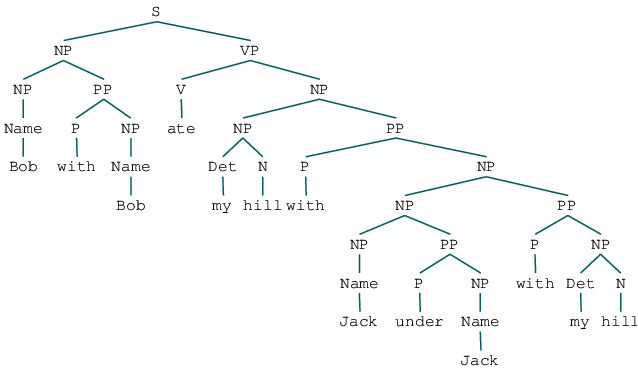

In [4]:
my_tree=pcfg_generate(toy_pcfg2)
my_tree

<a name="q2.1.2"></a>
<h4>2.1.2 Generate 1,000 Trees</h4>

Generate 1,000 random trees using nltk.grammar.toy_pcfg2 - store the resulting trees in a file "toy_pcfg2.gen".

In [5]:
def generator (howmany):
    for i in range(1000):
        yield pcfg_generate(toy_pcfg2)
        
g = generator(1000)

with open('toy_pcfg2.gen', 'w') as f:
    for x in g:
        f.write(str(x).replace("\n", ""))
        f.write("\n")

<a name="q2.1.3"></a>
<h4>2.1.3 Gather Rules Frequency for all Non-Terminals</h4>
    
Compute the rules frequency distribution of each non-terminal and pre-terminal in the generated corpus.
You can look at the code of <a href="http://www.nltk.org/_modules/nltk/grammar.html#induce_pcfg">nltk.induce_pcfg(root, productions)</a> to see how this can be done.
You should construct one distribution per non-terminal.

In [7]:
tree_list=[]
with open('toy_pcfg2.gen', 'r') as f:
        my_tree=f.readlines()
        for i in range(1000):
            t = Tree.fromstring(my_tree[i])
            tree_list.append(t.productions())
trees=[x for tree in tree_list for x in tree]

In [9]:
from nltk.grammar import induce_pcfg
S=Nonterminal('S')
pcfg_gen=induce_pcfg(S,trees)
productions = pcfg_gen.productions()
print(productions,'\n')

[S -> NP VP [1.0], NP -> Name [0.280616], Name -> 'Bob' [0.463009], VP -> V NP [0.593843], V -> 'ran' [0.276], NP -> Det N [0.406578], Det -> 'my' [0.294894], N -> 'hill' [0.496271], Det -> 'the' [0.379805], Name -> 'Jack' [0.536991], V -> 'ate' [0.503], Det -> 'a' [0.325301], N -> 'telescope' [0.151463], NP -> NP PP [0.312806], PP -> P NP [1.0], P -> 'under' [0.385015], P -> 'with' [0.614985], N -> 'boy' [0.110729], N -> 'table' [0.118187], VP -> V [0.399206], V -> 'saw' [0.221], N -> 'cookie' [0.123351], VP -> VP PP [0.00695134]] 



In [10]:
nonterminals=[]
for pr in productions:
    if str(pr.lhs()) not in nonterminals:
        nonterminals.append(str(pr.lhs()))
nonterminals

['S', 'NP', 'Name', 'VP', 'V', 'Det', 'N', 'PP', 'P']

In [11]:
rules={}
for n in nonterminals:
    rules[n]=pcfg_gen.productions(Nonterminal(n))
rules

{'S': [S -> NP VP [1.0]],
 'NP': [NP -> Name [0.280616], NP -> Det N [0.406578], NP -> NP PP [0.312806]],
 'Name': [Name -> 'Bob' [0.463009], Name -> 'Jack' [0.536991]],
 'VP': [VP -> V NP [0.593843], VP -> V [0.399206], VP -> VP PP [0.00695134]],
 'V': [V -> 'ran' [0.276], V -> 'ate' [0.503], V -> 'saw' [0.221]],
 'Det': [Det -> 'my' [0.294894],
  Det -> 'the' [0.379805],
  Det -> 'a' [0.325301]],
 'N': [N -> 'hill' [0.496271],
  N -> 'telescope' [0.151463],
  N -> 'boy' [0.110729],
  N -> 'table' [0.118187],
  N -> 'cookie' [0.123351]],
 'PP': [PP -> P NP [1.0]],
 'P': [P -> 'under' [0.385015], P -> 'with' [0.614985]]}

<a name="q2.1.4"></a>
<h4>2.1.4 Compute KL-Divergence between a priori and generated parameters</h4>
    
For each distribution, compute the KL-divergence between the MLE estimation of the probability
distribution constructed on your test corpus and toy_pcfg2.
The MLE estimation is obtained by applying the <a href="http://www.nltk.org/_modules/nltk/probability.html#MLEProbDist">MLEProbDist</a> estimator to the observed empirical frequency distribution.
KL-divergence (<a href="http://en.wikipedia.org/wiki/Kullback-Leibler_divergence">Kullback-Leibler divergence</a>
also known as relative entropy) estimates the difference between two distributions.
<p/>
Read some precisions on handling <a href='KL.html'>diverging KL computations</a> when the support of the 2 distributions p and q are not identical.
<p/>

Explain your observations.

In [12]:
priori= toy_pcfg2.productions()
prior_rules={}
for n in nonterminals:
    prior_rules[n]=toy_pcfg2.productions(Nonterminal(n))
prior_rules

{'S': [S -> NP VP [1.0]],
 'NP': [NP -> Det N [0.41], NP -> Name [0.28], NP -> NP PP [0.31]],
 'Name': [Name -> 'Jack' [0.52], Name -> 'Bob' [0.48]],
 'VP': [VP -> V NP [0.59], VP -> V [0.4], VP -> VP PP [0.01]],
 'V': [V -> 'saw' [0.21], V -> 'ate' [0.51], V -> 'ran' [0.28]],
 'Det': [Det -> 'the' [0.41], Det -> 'a' [0.31], Det -> 'my' [0.28]],
 'N': [N -> 'boy' [0.11],
  N -> 'cookie' [0.12],
  N -> 'table' [0.13],
  N -> 'telescope' [0.14],
  N -> 'hill' [0.5]],
 'PP': [PP -> P NP [1.0]],
 'P': [P -> 'with' [0.61], P -> 'under' [0.39]]}

the support of the 2 distributions is identical then we can use the probabilities as it.

In [13]:
import math
kl={}
for n in nonterminals:
    summ=0
    for pr in rules[n]:
        p= pr.prob()
        Q=[x for x in prior_rules[n] if x.rhs()== pr.rhs()]
        q= Q[0].prob()
        summ+=p*math.log(p/q)
    kl[n]=summ
kl

{'S': 0.0,
 'NP': 2.7659655732697064e-05,
 'Name': 0.0005789411719833958,
 'VP': 0.0005340792886838444,
 'V': 0.00036016173391123854,
 'Det': 0.0019010649411084525,
 'N': 0.0010734286482714985,
 'PP': 0.0,
 'P': 5.231308356467429e-05}

we can see that in S and PP the kl is 0 because in the 2 cases the distribution in both test and original data is the same(only one possible rule) in other nonterminals the kl is not 0 but is very low so we can conclude that the distribution in the 2 cases is pretty similar.

<a name="q2.2"></a>
<h3>Question 2.2: Learn a PCFG from a Treebank</h3>

In this question, we will learn a PCFG from a treebank with different
types of tree annotations.  We start from a subset of 200 trees from
the Penn Treebank (which is distributed by <a href="http://www.nltk.org">NLTK</a>
in the corpus named "treebank" - the NLTK version contains about 4,000 trees).
<p/>

In this question, we want to induce a PCFG from the treebank and
investigate its properties.  For reference, NLTK provides a function
called <a href="http://www.nltk.org/_modules/nltk/grammar.html#induce_pcfg">induce_pcfg</a>
in the nltk.grammar module.  It starts from a set of productions and constructs a weighted grammar with the MLE
estimation of the production distributions.


<a name="q2.2.1"></a>
<h4>2.2.1 Induce_PCFG</h4>

At this stage, we learn the PCFG "as is" -- without Chomsky Form Normalization -- but with "simplified" tags. 
That is, we must use a function to simplify all tags in the tree (non-terminal and terminal): 

In [14]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /Users/gab/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [15]:
from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader

def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    return tag

treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')

# Raw form
print(treebank.parsed_sents()[:1])

# Pretty print
print(treebank.parsed_sents()[0])

# we need to transform the tree to remove NONE tags and simplify tags.

[Tree('S', [Tree('NP-SBJ', [Tree('NP', [Tree('NNP', ['Pierre']), Tree('NNP', ['Vinken'])]), Tree(',', [',']), Tree('ADJP', [Tree('NP', [Tree('CD', ['61']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])]), Tree(',', [','])]), Tree('VP', [Tree('MD', ['will']), Tree('VP', [Tree('VB', ['join']), Tree('NP', [Tree('DT', ['the']), Tree('NN', ['board'])]), Tree('PP-CLR', [Tree('IN', ['as']), Tree('NP', [Tree('DT', ['a']), Tree('JJ', ['nonexecutive']), Tree('NN', ['director'])])]), Tree('NP-TMP', [Tree('NNP', ['Nov.']), Tree('CD', ['29'])])])]), Tree('.', ['.'])])]
(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


We want all tags of the form "NP-SBJ-2" to be simplified into "NP".  We also want to filter out "NONE" elements from the treebank.  
You must find the best way to perform NONE filtering on the trees. (NONE elements appear in the original Penn Treebank for example in the case of relative clauses.)

<pre class="prettyprint">
pcfg_learn(treebank, n)
-- treebank is the nltk.corpus.treebank lazy corpus reader
-- n indicates the number of trees to read
-- return an nltk.PCFG instance
</pre>

Use the following code as a starting point:

In [ ]:
from nltk.grammar import Production
from nltk import Tree, Nonterminal

def get_tag(tree):
    if isinstance(tree, Tree):
        return Nonterminal(simplify_functional_tag(tree.label()))
    else:
        return tree

def tree_to_production(tree):
    return Production(get_tag(tree), [get_tag(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                yield prod

In [208]:
dataset = treebank.parsed_sents()

In [209]:
def remove_none(trees):
    for tree in trees:
        for sub in tree.subtrees():
            for n, child in enumerate(sub):
                if isinstance(child, str):
                    continue
                if len(list(child.subtrees(filter=lambda x:x.label()=='-NONE-')))==len(child.leaves()):
                    del sub[n]
            
remove_none(dataset)

In [210]:
from nltk.tree import Tree
def simplify_trees(trees):
    def convert_tree_labels(tree): 
        children = []
        for t in tree:
            if isinstance(t, Tree):
                children.append(convert_tree_labels(t)) 
            else:
                children.append(t)
        label = simplify_functional_tag(tree.label()) 
        return Tree(label, children)
  
    return [convert_tree_labels(tree) for tree in trees]

dataset_simplified = simplify_trees(dataset)

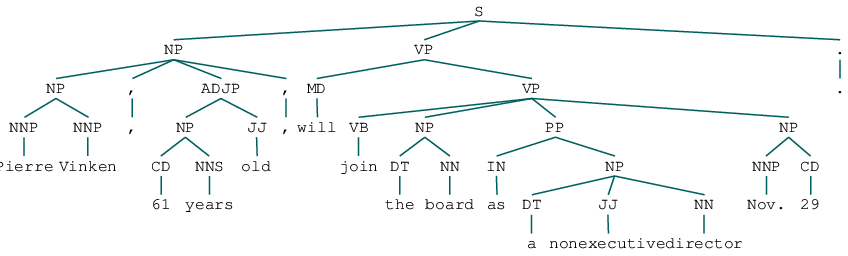

In [211]:
dataset_simplified[0]

In [20]:
import random
data200=random.sample(dataset_simplified,200)
data= [x.productions() for x in data200]
dataa=[x for tree in data for x in tree]

In [21]:
probs=induce_pcfg(S,dataa).productions()
probs[0:10]

[S -> CC NP VP . [0.0143149],
 CC -> 'And' [0.015625],
 NP -> DT NN NNS [0.00224719],
 DT -> 'some' [0.0144928],
 NN -> 'grain' [0.0013624],
 NNS -> 'analysts' [0.00949367],
 VP -> VBP VP [0.022069],
 VBP -> 'are' [0.215385],
 VP -> VBG SBAR [0.00551724],
 VBG -> 'predicting' [0.0136986]]

<a name="q2.2.2"></a>
<h4>2.2.2 Data Exploration and Validation</h4>

Explore the following properties of the learned PCFG:
<ul>
<li>How many productions are learned from the trees? How many interior nodes were in the treebank?
<li>Draw a plot of the distribution of productions according to their frequency (number of rules with frequency 1, 2, ...).  What do you observe?
<li>Induce a PCFG from 200 trees, and another one from 400 trees - compare the distribution of the rules you learn.
</ul>

In [22]:
print("number of productions learned from the trees: ",len(probs))

number of productions learned from the trees:  2712


In [23]:
count=0
for tree in data200:
    for h in range(2,tree.height()):
        for t in tree.subtrees(lambda t: t.height() == h):
            count+=1
print("number of interior nodes in the tree bank:",count)

number of interior nodes in the tree bank: 8897


<AxesSubplot:ylabel='count'>

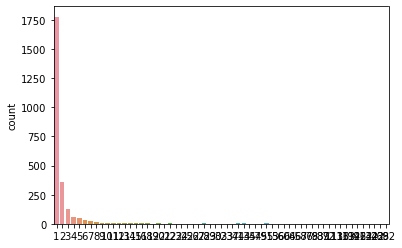

In [27]:
import seaborn as sns
import numpy as np
from nltk.probability import FreqDist
count=FreqDist([x.rhs() for x in dataa])
x = np.arange(len(count))
d=[d for d in count.values()]
sns.countplot(x=d)

looking at first 15 frequants


<AxesSubplot:ylabel='count'>

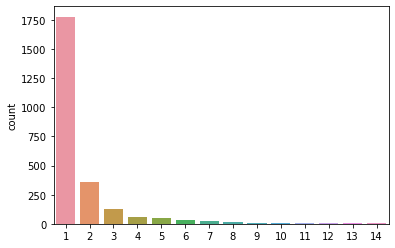

In [28]:
big=[x for x in count.values() if x<15]
x = np.arange(len(big))
print("looking at first 15 frequants")
sns.countplot(x=big)

In [29]:
data400=random.sample(dataset_simplified,400)
data400= [x.productions() for x in data400]
dataa400=[x for tree in data400 for x in tree]
probs400=induce_pcfg(S,dataa400).productions()

In [30]:
print("number of productions learned from the trees with 400 trees: ",len (probs400))

number of productions learned from the trees with 400 trees:  4452


<AxesSubplot:ylabel='count'>

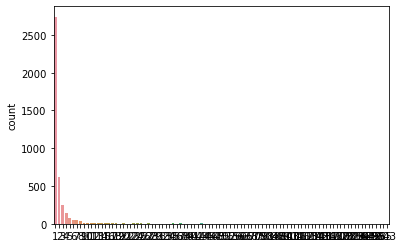

In [31]:
count400=FreqDist([x.rhs() for x in dataa400])
x = np.arange(len(count400))
d=[d for d in count400.values()]
sns.countplot(x=d)

looking at first 15 frequants


<AxesSubplot:ylabel='count'>

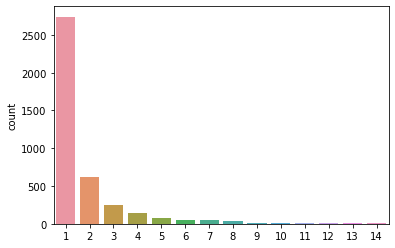

In [32]:
big=[x for x in count400.values() if x<15]
x = np.arange(len(big))
print("looking at first 15 frequants")
sns.countplot(x=big)

when we compare between the rules made from 200 and 400 trees we can see that with 400 trees we got about 1.6 time more rules 4452 vs 2712, that mean that in the new data we add we learn lots of new rules.
the distribution of rules according to frequancy is similar in both case- showing a small amound of rules that appears a lot and a big amound of rules that appears only once.

<a name="q2.3"></a>
<h3>Question 2.3: Induce a PCFG in Chomsky Normal Form</h3>

<a name="q2.3.1"></a>
<h4>2.3.1 PCFG_CNF_Learn</h4>

Implement <code>pcfg_cnf_learn</code>

We now want to learn a PCFG in Chomsky Normal Form from the treebank, with simplified tags, and with filtered NONE elements.
The strategy is to convert the trees in the treebank into CNF, then to induce the PCFG from the transformed trees.
Use the function <code>chomsky_normal_form</code> in <a href="http://www.nltk.org/_modules/nltk/treetransforms.html">nltk.treetransforms</a> to convert the trees.  
Pay attention to NONE filtering.  Use horizontal Markov annotation and parent annotation:

<code>
chomsky_normal_form(tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
</code>

<pre class="prettyprint">
pcfg_cnf_learn(treebank, n)
-- treebank is the nltk.corpus.treebank lazy corpus reader (simplified tags)
-- n indicates the number of trees to read
-- return an nltk.PCFG in CNF
</pre>

In [33]:
from nltk.treetransforms import chomsky_normal_form

def pcfg_cnf_learn(treebank, n):
    cnf_data=random.sample(treebank,n)
    for tree in cnf_data:
        chomsky_normal_form(tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
    return cnf_data

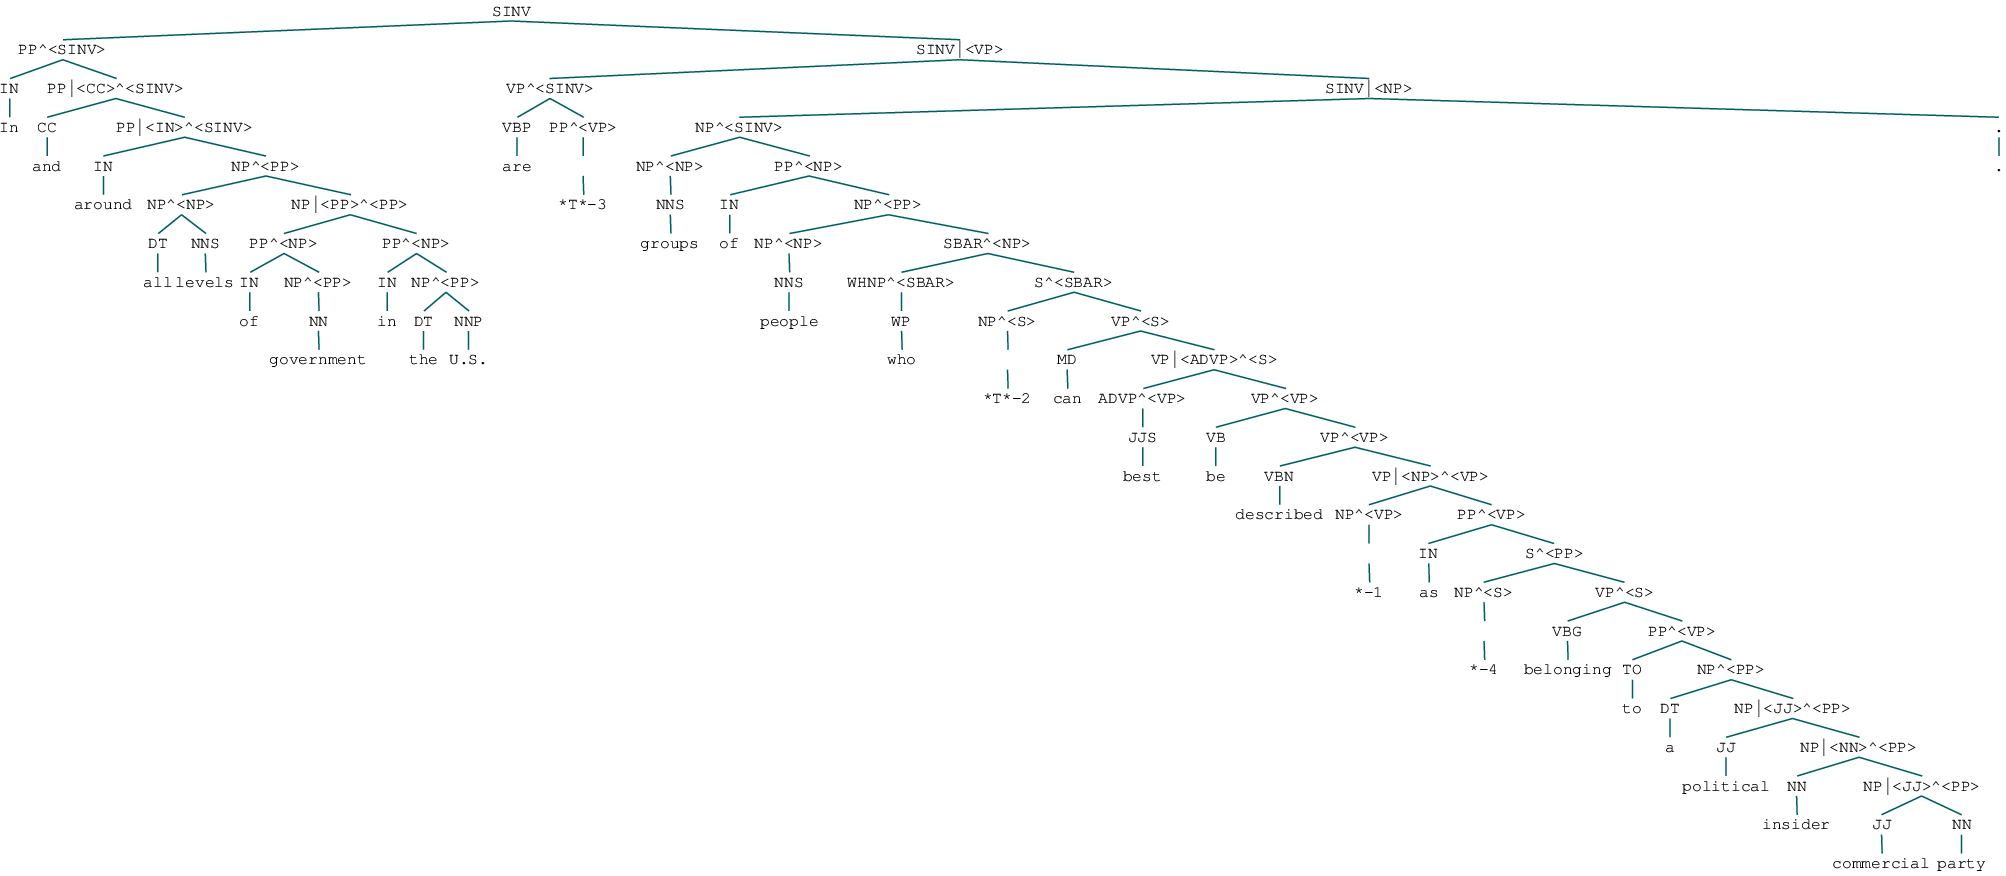

In [34]:
cnf_data=pcfg_cnf_learn(dataset_simplified, 200)
cnf_dataset= [x.productions() for x in cnf_data]
cnf_data[0]

In [35]:
sliced_data=[x for tree in cnf_dataset for x in tree]
cnf_probs=induce_pcfg(S,sliced_data).productions()
cnf_probs[0:10]

[SINV -> PP^<SINV> SINV|<VP> [0.181818],
 PP^<SINV> -> IN PP|<CC>^<SINV> [0.5],
 IN -> 'In' [0.0242537],
 PP|<CC>^<SINV> -> CC PP|<IN>^<SINV> [1.0],
 CC -> 'and' [0.684685],
 PP|<IN>^<SINV> -> IN NP^<PP> [1.0],
 IN -> 'around' [0.00373134],
 NP^<PP> -> NP^<NP> NP|<PP>^<PP> [0.0226804],
 NP^<NP> -> DT NNS [0.0150659],
 DT -> 'all' [0.0151134]]

<a name="q2.3.2"></a>
<h4>2.3.2 Data Exploration</h4>

How many productions are learned from the CNF trees? How many interior nodes were in the original treebank, and in the CNF treebank?

Compare the CNF and non-CNF figures (ratios).  What do you conclude?

In [247]:
print("number of productions learned from the trees: ",len(cnf_probs))

number of productions learned from the trees:  3273


In [246]:
count=0
for tree in cnf_data:
    for h in range(1,tree.height()):
        for t in tree.subtrees(lambda t: t.height() == h):
            count+=1
print("number of interior nodes in the tree bank:",count)

number of interior nodes in the tree bank: 10589


In the non cnf case we got 2712 rules and with cnf we got 3273 it's a ratio of 1.2, that is suprizing since we thoght we will get much more rules by using cnf rules, in the number of interior nodes this also append we had 8897 nodes in non cnf trees and 10589 in cnf tree- that is again a ratio of 1.2.
This may append because much of the rules already are in a cnf form so only few rules were changed.

<a name="q2.4"></a>
<h3>Question 2.4: Test CFG Independence Assumptions</h3>

We want to test the CFG hypothesis that a node expansion is independent from its location within a tree.
<p/>

For the treebank before CNF transformation, report the following statistics, for the expansions of the NP category:
<ul>
<li>Compute the distribution of the RHS given the NP LHS for all NPs in the treebank.  Draw a histogram plot.
<li>Compute the same distribution only for NPs that appear directly below a S node (any variant of S in the Penn treebank tagset). Draw a histogram plot.
<li>Compute the same distribution only for NPs that appear directly below a VP node (any variant of VP in the Penn Treebank tagset). Draw a histogram plot. 
<li>Compare the distributions above.  Use KL-divergence.
<li>Conclude: does the data in the treebank confirm the CFG hypothesis for each configuration (original trees, annotated CNF trees)? 
    (How do you calibrate the values of the KL-divergence to decide that 2 values are similar?)
</ul>
<p/>


In [42]:
data= [x.productions() for x in dataset_simplified]
dataa=[x for tree in data for x in tree]
probs=induce_pcfg(S,dataa)

In [46]:
rhs_givenNp=probs.productions(Nonterminal('NP'))
rhs_givenNp[:10]

[NP -> NP , ADJP , [0.000180766],
 NP -> NNP NNP [0.0358821],
 NP -> CD NNS [0.00816462],
 NP -> DT NN [0.0824295],
 NP -> DT JJ NN [0.0257893],
 NP -> NNP CD [0.00253073],
 NP -> NP PP [0.10138],
 NP -> NN [0.0374187],
 NP -> NP , NP [0.010153],
 NP -> DT NNP VBG NN [3.01277e-05]]

histogram of the distribution of the RHS given the NP LHS for all NPs in the treebank


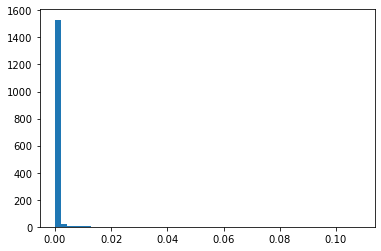

In [243]:
plt.hist([x.prob()for x in rhs_givenNp],bins=50)
print("histogram of the distribution of the RHS given the NP LHS for all NPs in the treebank")

In [197]:
def cut_np(tree):
    for x in tree:
        if x.label()=='NP':
            tree=x
    for x in tree.treepositions():
        if len(x)==1:
            if type(tree[x[0]])!=str:
                tree[x[0]]=tree[x[0]].label()
            
    return tree

In [198]:
np_branches=[]

for tree in dataset_simplified:
    np_branches.append(cut_np(tree))

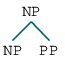

In [200]:
np_branches[200]

In [205]:
np_data= [x.productions() for x in np_branches]
np_dataa=[x for tree in np_data for x in tree]
np_probs=induce_pcfg(S,np_dataa)
rhs_givenNpafterS=np_probs.productions(Nonterminal('NP'))
rhs_givenNpafterS[:10]

[NP -> 'NP' ',' 'ADJP' ',' [0.00137552],
 NP -> 'NNP' 'NNP' [0.0850069],
 NP -> 'NP' ',' 'UCP' ',' [0.000550206],
 NP -> 'NNS' [0.042641],
 NP -> 'NP' ',' 'NP' ',' [0.0437414],
 NP -> 'DT' 'JJS' 'NNS' [0.000825309],
 NP -> 'DT' 'NNP' 'NN' [0.00935351],
 NP -> 'PRP' [0.117744],
 NP -> 'EX' [0.0088033],
 NP -> 'DT' 'NP' 'CC' 'NP' [0.00247593]]

histogram of the distribution of the RHS given the NP LHS only for NPs that appear directly below a S node


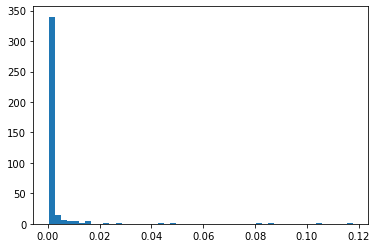

In [244]:
plt.hist([x.prob()for x in rhs_givenNpafterS],bins=50)
print("histogram of the distribution of the RHS given the NP LHS only for NPs that appear directly below a S node")

In [206]:
def cut_vp(tree):
    for x in tree:
        if x.label()=='VP':
            tree=x
    for x in tree.treepositions():
        if len(x)==1:
            if type(tree[x[0]])!=str:
                tree[x[0]]=tree[x[0]].label()
            
    return tree

In [212]:
vp_branches=[]

for tree in dataset_simplified:
    vp_branches.append(cut_vp(tree))

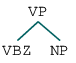

In [213]:
vp_branches[200]

In [214]:
vp_data= [x.productions() for x in vp_branches]
vp_dataa=[x for tree in vp_data for x in tree]
vp_probs=induce_pcfg(S,vp_dataa)
rhs_givenNpafterVP=vp_probs.productions(Nonterminal('NP'))
rhs_givenNpafterVP[:10]

[NP -> 'NNP' 'NNP' 'NNP' ':' [0.0078125],
 NP -> 'NN' ':' 'IN' 'NN' '.' [0.0078125],
 NP -> 'NNP' ':' [0.0234375],
 NP -> 'NNP' 'NNP' ':' [0.0234375],
 NP -> 'NP' ':' 'NP' '.' [0.210938],
 NP -> 'NNS' ':' [0.0078125],
 NP -> 'NN' ':' [0.0078125],
 NP -> 'NP' 'SBAR' '.' [0.0078125],
 NP -> 'LST' 'JJ' 'JJ' 'NN' '.' [0.0078125],
 NP -> 'NP' 'NP' '.' [0.0234375]]

histogram of the distribution of the RHS given the NP LHS only for NPs that appear directly below a VP node


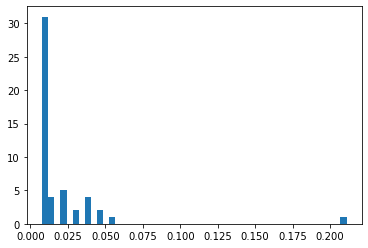

In [245]:
plt.hist([x.prob()for x in rhs_givenNpafterVP],bins=50)
print("histogram of the distribution of the RHS given the NP LHS only for NPs that appear directly below a VP node")

In [236]:
import math
CP=len(rhs_givenNpafterS)
CQ=len(rhs_givenNp)
minus = list(set(rhs_givenNp) - set(rhs_givenNpafterS))
SU = rhs_givenNpafterS + minus
CU=len(SU)
eps=0.00001
pc = eps*(CU-CP)/CP
qc = eps*(CU-CQ)/CQ

In [237]:
print("kl between distribution on all dataset and distribution only for NPs that appear directly below a S node")
for pr in rhs_givenNpafterS:
    p= pr.prob()-pc
    Q=[x for x in rhs_givenNp if x.rhs()== pr.rhs()]
    if len(Q)==0:
        q=eps
    else:
        q= Q[0].prob()
    summ+=p*math.log(p/q)
print(summ)

kl between distribution on all dataset and distribution only for NPs that appear directly below a S node
7.472218909154029


In [ ]:
CP=len(rhs_givenNpafterVP)
CQ=len(rhs_givenNp)
minus = list(set(rhs_givenNp) - set(rhs_givenNpafterVP))
SU = rhs_givenNpafterVP + minus
CU=len(SU)
eps=0.00001
pc = eps*(CU-CP)/CP
qc = eps*(CU-CQ)/CQ

In [238]:
print("kl between distribution on all dataset and distribution only for NPs that appear directly below a VP node")
for pr in rhs_givenNpafterVP:
    p= pr.prob()-pc
    Q=[x for x in rhs_givenNp if x.rhs()== pr.rhs()]
    if len(Q)==0:
        q=eps
    else:
        q= Q[0].prob()
    summ+=p*math.log(p/q)
print(summ)

kl between distribution on all dataset and distribution only for NPs that appear directly below a VP node
15.596004654155752


The data in the treebank doesn't confirm the CFG hypothesis,we can see that in case of np's under vp's the distribution is diffrent from the distribution of rules for np's in all dataset and also the kl divergence is high- 15.6.
In the case of np's after s's the form of distribution is more similar to distribution of rules for np's in total as seen in the histogram but the kl parameter is high so there are diffrences between the distributions. 


<hr/>
<a name="q3"></a>
<h2>Question 3: Building and Evaluating a Simple PCFG Parser</h2>

In this question, we will construct a Viterbi parser for the PCFG induced in Question 2 and perform evaluation of this statistical parser. 
<p/>

<a name="q3.1"></a>
<h3>Question 3.1: Build a Parser</h3>

<a name="q3.1.1"></a>
<h4>3.1.1 Dataset Split</h4>
    
Split the NLTK treebank corpus into 80% training (about 3,200 trees) and 20% (about 800 trees) testing sets.
<p/>

In [2]:
import nltk.corpus
from nltk import induce_pcfg, Nonterminal, Production, ViterbiParser
from sklearn.model_selection import train_test_split
from collections import defaultdict

nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\baraa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\treebank.zip.


True

In [3]:
dataset = nltk.corpus.treebank.parsed_sents()
train,test = train_test_split(dataset, test_size=0.2)
print(f'train size: {len(train)}, test size {len(test)} \n')
sents = [' '.join(tree.leaves()) for tree in train[:5]]
for sent in sents:
  print(sent)

train size: 3131, test size 783 

The school-board hearing at which she was dismissed *-2 *T*-1 was crowded *-4 with students , teachers and parents who *T*-98 came *-3 to testify on her behalf .
It 's probably worth * paying a premium for funds that *T*-42 invest in markets that *T*-43 are partially closed to foreign investors , such as South Korea , some specialists say 0 *T*-1 .
* Excluding one-time additions to profit in each year , earnings per share were $ 2.47 *U* , up 7.4 % from $ 2.30 *U* in fiscal 1988 .
Outside , a young pressman filling a news box with an extra edition headlined * `` Herald Examiner Closes '' refused *-1 to take a reader 's quarter .
Many institutional index funds are active program traders , *-1 swapping their stocks for futures when profitable * to do so *T*-2 .


In [4]:
def remove_none(trees):
  for tree in trees:
    for sub in tree.subtrees():
        for n, child in enumerate(sub):
            if isinstance(child, str):
                continue
            if len(list(child.subtrees(filter=lambda x:x.label()=='-NONE-')))==len(child.leaves()):
                del sub[n]
print(' '.join(train[0].leaves()))               
print(str(train[0]))  
print(' '.join(train[1].leaves()))
print(str(train[1])) 
print(' '.join(train[2].leaves())) 
print(str(train[2]))              
remove_none(train)
remove_none(test)


The school-board hearing at which she was dismissed *-2 *T*-1 was crowded *-4 with students , teachers and parents who *T*-98 came *-3 to testify on her behalf .
(S
  (NP-SBJ-4
    (NP (DT The) (NN school-board) (NN hearing))
    (SBAR-LOC
      (WHPP-1 (IN at) (WHNP (WDT which)))
      (S
        (NP-SBJ-2 (PRP she))
        (VP
          (VBD was)
          (VP
            (VBN dismissed)
            (NP (-NONE- *-2))
            (PP-LOC (-NONE- *T*-1)))))))
  (VP
    (VBD was)
    (VP
      (VBN crowded)
      (NP (-NONE- *-4))
      (PP-CLR
        (IN with)
        (NP
          (NP
            (NNS students)
            (, ,)
            (NNS teachers)
            (CC and)
            (NNS parents))
          (SBAR
            (WHNP-98 (WP who))
            (S
              (NP-SBJ-3 (-NONE- *T*-98))
              (VP
                (VBD came)
                (S-PRP
                  (NP-SBJ (-NONE- *-3))
                  (VP
                    (TO to)
                    (VP


In [5]:
print(str(train[0]))  
print(str(train[1]))  
print(str(train[2]))   

(S
  (NP-SBJ-4
    (NP (DT The) (NN school-board) (NN hearing))
    (SBAR-LOC
      (WHPP-1 (IN at) (WHNP (WDT which)))
      (S
        (NP-SBJ-2 (PRP she))
        (VP (VBD was) (VP (VBN dismissed) (PP-LOC ))))))
  (VP
    (VBD was)
    (VP
      (VBN crowded)
      (PP-CLR
        (IN with)
        (NP
          (NP
            (NNS students)
            (, ,)
            (NNS teachers)
            (CC and)
            (NNS parents))
          (SBAR
            (WHNP-98 (WP who))
            (S
              (VP
                (VBD came)
                (S-PRP
                  (VP
                    (TO to)
                    (VP
                      (VB testify)
                      (PP-CLR (IN on) (NP (PRP$ her) (NN behalf)))))))))))))
  (. .))
(S
  (S-TPC-1
    (NP-SBJ (PRP It))
    (VP
      (VBZ 's)
      (ADVP (RB probably))
      (ADJP-PRD
        (IN worth)
        (S-NOM
          (VP
            (VBG paying)
            (NP (DT a) (NN premium))
            (PP-CLR
  

In [6]:
from nltk.tree import Tree
def simplify_trees(trees):
  def convert_tree_labels(tree): 
    children = []
    for t in tree:
      if isinstance(t, Tree):
        children.append(convert_tree_labels(t)) 
      else:
        children.append(t)
    label = simplify_functional_tag(tree.label()) 
    return Tree(label, children)
  
  return [convert_tree_labels(tree) for tree in trees]

train_simplified = simplify_trees(train)
test_simplified = simplify_trees(test)


In [7]:
str(train[0])

'(S\n  (NP-SBJ-4\n    (NP (DT The) (NN school-board) (NN hearing))\n    (SBAR-LOC\n      (WHPP-1 (IN at) (WHNP (WDT which)))\n      (S\n        (NP-SBJ-2 (PRP she))\n        (VP (VBD was) (VP (VBN dismissed) (PP-LOC ))))))\n  (VP\n    (VBD was)\n    (VP\n      (VBN crowded)\n      (PP-CLR\n        (IN with)\n        (NP\n          (NP\n            (NNS students)\n            (, ,)\n            (NNS teachers)\n            (CC and)\n            (NNS parents))\n          (SBAR\n            (WHNP-98 (WP who))\n            (S\n              (VP\n                (VBD came)\n                (S-PRP\n                  (VP\n                    (TO to)\n                    (VP\n                      (VB testify)\n                      (PP-CLR (IN on) (NP (PRP$ her) (NN behalf)))))))))))))\n  (. .))'

In [8]:
str(train_simplified[0])

'(S\n  (NP\n    (NP (DT The) (NN school-board) (NN hearing))\n    (SBAR\n      (WHPP (IN at) (WHNP (WDT which)))\n      (S (NP (PRP she)) (VP (VBD was) (VP (VBN dismissed) (PP ))))))\n  (VP\n    (VBD was)\n    (VP\n      (VBN crowded)\n      (PP\n        (IN with)\n        (NP\n          (NP\n            (NNS students)\n            (, ,)\n            (NNS teachers)\n            (CC and)\n            (NNS parents))\n          (SBAR\n            (WHNP (WP who))\n            (S\n              (VP\n                (VBD came)\n                (S\n                  (VP\n                    (TO to)\n                    (VP\n                      (VB testify)\n                      (PP (IN on) (NP (PRP$ her) (NN behalf)))))))))))))\n  (. .))'

In [9]:
from nltk.tree import Tree
def replace_words_with_pos_tags(trees):
  def convert_tree_leaves(tree): 
    children = []
    for t in tree:
      if isinstance(t, Tree):
        children.append(convert_tree_leaves(t)) 
      else:
        children.append(tree.label().lower())
    label = simplify_functional_tag(tree.label()) 
    return Tree(label, children)
  
  return [convert_tree_leaves(tree) for tree in trees]

train_pos_tags = replace_words_with_pos_tags(train_simplified)
test_pos_tags = replace_words_with_pos_tags(test_simplified)

In [10]:
str(train_simplified[0])

'(S\n  (NP\n    (NP (DT The) (NN school-board) (NN hearing))\n    (SBAR\n      (WHPP (IN at) (WHNP (WDT which)))\n      (S (NP (PRP she)) (VP (VBD was) (VP (VBN dismissed) (PP ))))))\n  (VP\n    (VBD was)\n    (VP\n      (VBN crowded)\n      (PP\n        (IN with)\n        (NP\n          (NP\n            (NNS students)\n            (, ,)\n            (NNS teachers)\n            (CC and)\n            (NNS parents))\n          (SBAR\n            (WHNP (WP who))\n            (S\n              (VP\n                (VBD came)\n                (S\n                  (VP\n                    (TO to)\n                    (VP\n                      (VB testify)\n                      (PP (IN on) (NP (PRP$ her) (NN behalf)))))))))))))\n  (. .))'

In [11]:
str(train_pos_tags[0])

'(S\n  (NP\n    (NP (DT dt) (NN nn) (NN nn))\n    (SBAR\n      (WHPP (IN in) (WHNP (WDT wdt)))\n      (S (NP (PRP prp)) (VP (VBD vbd) (VP (VBN vbn) (PP ))))))\n  (VP\n    (VBD vbd)\n    (VP\n      (VBN vbn)\n      (PP\n        (IN in)\n        (NP\n          (NP (NNS nns) (, ,) (NNS nns) (CC cc) (NNS nns))\n          (SBAR\n            (WHNP (WP wp))\n            (S\n              (VP\n                (VBD vbd)\n                (S\n                  (VP\n                    (TO to)\n                    (VP\n                      (VB vb)\n                      (PP (IN in) (NP (PRP$ prp$) (NN nn)))))))))))))\n  (. .))'

<a name="q3.1.2"></a>
<h4>3.1.2 Learn a PCFG over the Chomsky Normal Form version of this treebank</h4>
<p/>

In [239]:
def learn_pcfg(trees):
  res = defaultdict(lambda: defaultdict(lambda: 0))
  productions = []
  for tree in trees:
    tree_prods = list(tree.productions())
    for prod in tree_prods:
      lhs = prod.lhs()._symbol
      lhs = Nonterminal(lhs)
      rhs = [Nonterminal(x._symbol) if type(x) is nltk.grammar.Nonterminal else x  for x in prod.rhs() ]
      rule = Production(lhs,rhs)
      productions.append(rule)

  pcfg = induce_pcfg(Nonterminal('S'),productions)
  return pcfg

def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    return tag

In [12]:
for t in train_pos_tags:
  t.chomsky_normal_form()
for t in test_pos_tags:
  t.chomsky_normal_form()


pcfg = learn_pcfg(test_pos_tags)

In [13]:
pcfg

<Grammar with 2698 productions>

In [14]:
' '.join(test_pos_tags[0].leaves())

'in nnp nnp nnp nnp jj nn nn , nnp nnps vbd in $ cd , rb cd nns .'

In [15]:
' '.join(train_pos_tags[0].leaves())

'dt nn nn in wdt prp vbd vbn vbd vbn in nns , nns cc nns wp vbd to vb in prp$ nn .'

<a name="q3.1.3"></a>
<h4>3.1.3 Viterbi Parser</h4>
    
Construct a <code><a href="https://www.nltk.org/_modules/nltk/parse/viterbi.html">ViterbiParser</a></code> using this PCFG grammar.
Test the parser on a few sentences.

In [16]:
VP = ViterbiParser(pcfg)

In [17]:
%%time
x = VP.parse('dt nn in jj nn cc nn vbd in nnp in nnp cc md vb to cd jj jj nns .'.split())
for y in x:
  print(y)

(S
  (NP
    (NP (DT dt) (NN nn))
    (PP
      (IN in)
      (NP
        (JJ jj)
        (NP|<NN-CC-NN>
          (NN nn)
          (NP|<CC-NN> (CC cc) (NN nn))))))
  (S|<VP-.>
    (VP
      (VP
        (VBD vbd)
        (VP|<PP-PP>
          (PP (IN in) (NP (NNP nnp)))
          (PP (IN in) (NP (NNP nnp)))))
      (VP|<CC-VP>
        (CC cc)
        (VP
          (MD md)
          (VP
            (VB vb)
            (PP
              (TO to)
              (NP
                (CD cd)
                (NP|<JJ-JJ-NNS>
                  (JJ jj)
                  (NP|<JJ-NNS> (JJ jj) (NNS nns)))))))))
    (. .))) (p=1.28767e-21)
Wall time: 23.7 s


In [18]:
%%time
x = VP.parse('rb , nns vbd dt jj nn in nn in dt nn , in prp vbz wrb to vb dt `` nn nn '' nn in rbr dt nn vbd rb vbn in vbg jj nns pos nn .'.split())
for y in x:
  print(y)

(S
  (ADVP (RB rb))
  (S|<,-NP-VP-.>
    (, ,)
    (S|<NP-VP-.>
      (NP (NNS nns))
      (S|<VP-.>
        (VP
          (VBD vbd)
          (VP|<NP-PP>
            (NP (DT dt) (NP|<JJ-NN> (JJ jj) (NN nn)))
            (PP
              (IN in)
              (NP
                (NP
                  (NP (NN nn))
                  (NP|<PP-POS>
                    (PP
                      (IN in)
                      (NP
                        (NP (DT dt) (NN nn))
                        (NP|<,-SBAR>
                          (, ,)
                          (SBAR
                            (IN in)
                            (S
                              (NP (PRP prp))
                              (VP
                                (VBZ vbz)
                                (SBAR
                                  (WHADVP (WRB wrb))
                                  (S
                                    (VP
                                      (TO to)
                         

<a name="q3.2"></a>
<h3>Question 3.2: Evaluate the Parser</h3>

Your task is to compute the ParsEval metric for the constituent-based parse trees on the test dataset of our treebank.  
Report the following metrics:
<ol>
<li>Precision
<li>Recall
<li>F-measure
<li>Labelled Precision
<li>Labelled Recall
<li>Labelled F-Measure
</ol>

Where precision and recall are computed over "constituents" between the parsed trees and the treebank trees: a constituent is a triplet 
(interior_node, first_index, last_index) - where first_index is the index of the first word in the sentence covered by the interior node,
and last_index that of the last word (that is, [first_index, last_index] is the yield of the interior node).
<p/>

In labelled precision and recall we count that 2 constituents match if they have the same label for the interior node.  
For unlabelled metrics, we just compare the first and last indexes.  
Make sure you compare the trees from the treebank after they have been simplified: for example, S-TPC-1 must be compared with S and ADVP-TMP with ADVP, and -NONE- nodes have been eliminated.
<p/>

You can read more on this metric in the following references:
<ol>
<li><a href="http://courses.washington.edu/ling571/ling571_fall_2010/slides/evalb_improved_pcky.pdf">An assignment on parsing evaluation by Scott Farrar</a> includes detailed explanation and examples on how the metric is computed.
<li><a href="http://nlp.cs.nyu.edu/evalb/">Evalb</a> software: this is the C program used in all standard evaluations of constituent parsers (by Satoshi Sekine and Michael  Collins).
<li><a href="http://nlp.stanford.edu/nlp/javadoc/javanlp/edu/stanford/nlp/parser/metrics/Evalb.html">Evalb in Java</a> for those who prefer reading Java over C - is part of the Stanford CoreNLP package.
</ol>

The specific steps to follow are:
<ul>
<li>Generate a list of labelled constituents of the form <code>[label first_index last_index]</code> given a parse tree.</li>
<li>Compute unlabelled Precision, Recall and F-measure for your parser on the test dataset</li>
<li>Compute labelled Precision, Recall and F-measure for your parser on the test dataset</li>
</ul>

In [19]:
predicted_test = [VP.parse(tree.leaves()) for tree in test_pos_tags]

In [20]:
%%time
exceptions = 0
reps = []
predicted_trees = []
for generaor in predicted_test:
    for tree in generaor:
        reps += [str(tree)]
        predicted_trees += [tree]
        break;
    exceptions +=1
    if exceptions % 10 == 0 :
        print(exceptions)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
Wall time: 17h 39min 12s


In [21]:
predicted_trees[:10]

[ProbabilisticTree('S', [ProbabilisticTree('PP', [ProbabilisticTree('IN', ['in']) (p=1.0), ProbabilisticTree('NP', [ProbabilisticTree('NP', [ProbabilisticTree('NNP', ['nnp']) (p=1.0), ProbabilisticTree('NP|<NNP-NNP-NNP-JJ-NN>', [ProbabilisticTree('NNP', ['nnp']) (p=1.0), ProbabilisticTree('NP|<NNP-NNP-JJ-NN>', [ProbabilisticTree('NNP', ['nnp']) (p=1.0), ProbabilisticTree('NP|<NNP-JJ-NN>', [ProbabilisticTree('NNP', ['nnp']) (p=1.0), ProbabilisticTree('NP|<JJ-NN>', [ProbabilisticTree('JJ', ['jj']) (p=1.0), ProbabilisticTree('NN', ['nn']) (p=1.0)]) (p=1.0)]) (p=1.0)]) (p=1.0)]) (p=1.0)]) (p=0.0004769475357710652), ProbabilisticTree('NN', ['nn']) (p=1.0)]) (p=2.4264421533663092e-06)]) (p=1.9850415537414608e-06), ProbabilisticTree('S|<,-NP-VP-.>', [ProbabilisticTree(',', [',']) (p=1.0), ProbabilisticTree('S|<NP-VP-.>', [ProbabilisticTree('NP', [ProbabilisticTree('NNP', ['nnp']) (p=1.0), ProbabilisticTree('NNPS', ['nnps']) (p=1.0)]) (p=0.001589825119236884), ProbabilisticTree('S|<VP-.>', [Pr

In [22]:
' '.join(predicted_trees[0].leaves())

'in nnp nnp nnp nnp jj nn nn , nnp nnps vbd in $ cd , rb cd nns .'

In [23]:
children = lambda tree:  [child for child in tree]
def pre_terminal(subtree):
  ch = children(subtree)
  return all(type(child) == str for child in ch)

def get_subtrees_triplets(tree,tree_offset):
  first_index = tree_offset
  res = []
  for sub_tree in tree:
    if pre_terminal(sub_tree):
      res.append( (sub_tree.label(),tree_offset,tree_offset+1) )
      tree_offset = tree_offset + 1
    else: 
      triplets,_,last_index = get_subtrees_triplets(sub_tree,tree_offset)
      res += triplets
      tree_offset = last_index
  res.append( (tree.label(),first_index,tree_offset) )
  return res, first_index, tree_offset
triplests_predicted, first,last = get_subtrees_triplets(predicted_trees[0],0)
triplests_gold, first,last = get_subtrees_triplets(test_pos_tags[0],0)

In [24]:
triplests_predicted[:3]

[('IN', 0, 1), ('NNP', 1, 2), ('NNP', 2, 3)]

In [25]:
triplests_gold[:3]

[('IN', 0, 1), ('NNP', 1, 2), ('NNP', 2, 3)]

In [33]:
predicted_trees2 = [get_subtrees_triplets(tree,0)[0] for tree in predicted_trees]
gold_trees2 = [get_subtrees_triplets(tree,0)[0] for tree in test_pos_tags]

def get_number_of_constituents(trees):
  s = sum([len(x) for x in trees])
  return s
def get_number_of_correct_constituents(predicted, gold, labeled=True):
    convert = lambda x: x if  labeled else (x[1],x[2])
    assert(len(predicted) == len(gold))
    res = 0
    for i in range(len(predicted)):
        predicted_tree = predicted[i]
        gold_tree = gold[i]  
        for constituent in predicted_tree:
            if any(convert(constituent) == convert(c) for c in gold_tree):
                res += 1
    return res

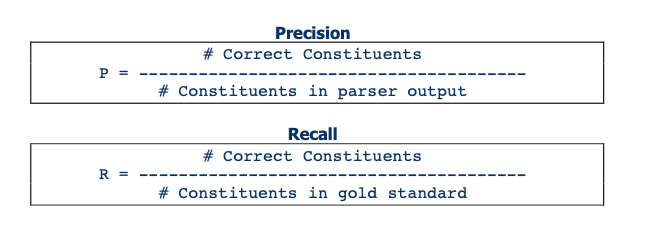

In [34]:
NOF_predicted_constit = get_number_of_constituents(predicted_trees2)
NOF_gold_constit = get_number_of_constituents(gold_trees2)
NOF_correct_labeled = get_number_of_correct_constituents(predicted_trees2,gold_trees2[:-1], labeled=True)
NOF_correct_unlabeled = get_number_of_correct_constituents(predicted_trees2,gold_trees2[:-1], labeled=False)
formatter = lambda x:("%.2f" % (x * 100)) + ' %'
f_measure = lambda P, R, beta=1: (beta*beta + 1)*P*R/((beta*beta)*P + R) 
#labeled recall
L_R = NOF_correct_labeled/NOF_gold_constit
print(f'labeled recall: {formatter(L_R)}')

#labeled precision
L_P = NOF_correct_labeled/NOF_predicted_constit
print(f'labeled precision: {formatter(L_P)}')

#labeled F-measure
print(f'labeled F-measure(beta = 1): {f_measure(L_P, L_R, beta = 1)}')
print(f'labeled F-measure(beta = 0.5): {f_measure(L_P, L_R, beta = 0.5)}')
print(f'labeled F-measure(beta = 2): {f_measure(L_P, L_R, beta = 2)}')

print(f'######')
#unlabeled recall
UN_R = NOF_correct_unlabeled/NOF_gold_constit
print(f'unlabeled recall: {formatter(UN_R)}')

#unlabeled precision
UN_P = NOF_correct_unlabeled/NOF_predicted_constit
print(f'unlabeled precision: {formatter(UN_P)}')

#unlabeled F-measure
print(f'unlabeled F-measure(beta = 1): {f_measure(UN_P, UN_R, beta = 1)}')
print(f'unlabeled F-measure(beta = 0.5): {f_measure(UN_P, UN_R, beta = 0.5)}')
print(f'unlabeled F-measure(beta = 2): {f_measure(UN_P, UN_R, beta = 2)}')



labeled recall: 80.55 %
labeled precision: 81.79 %
labeled F-measure(beta = 1): 0.8116485439320086
labeled F-measure(beta = 0.5): 0.8153784340314401
labeled F-measure(beta = 2): 0.8079526226734348
######
unlabeled recall: 86.73 %
unlabeled precision: 88.06 %
unlabeled F-measure(beta = 1): 0.8738657667791525
unlabeled F-measure(beta = 0.5): 0.8778815729998494
unlabeled F-measure(beta = 2): 0.8698865332935205


<a name="q3.3"></a>
<h3>Question 3.3: Accuracy per Distance</h3>

In general, parsers do a much better job on short constituents than long ones.  
Draw a plot of the accuracy of constituents per constituent length.  
The length of a constituent (node, first, last) is last-first+1.  
For a given constituent length X, accuracy is the number of constituents 
of length X in the parsed tree that are accurate divided by the total number of constituents of length X.

In [35]:
predicted_trees_triplets = [get_subtrees_triplets(tree,0) for tree in predicted_trees]
gold_trees_triplets = [get_subtrees_triplets(tree,0) for tree in test_pos_tags]
def constituents_of_length(trees,i):
  res = 0
  for tree in trees:
    for constituent in tree[0]:
      if constituent[2]-constituent[1] == i:
        res += 1
  return res 
def accuracy_of_length(predicted, gold,length, labeled=True):
    convert = lambda x: x if  labeled else (x[1],x[2])
    assert(len(predicted) == len(gold))
    res = 0
    for i in range(len(predicted)):
      predicted_tree = predicted[i]
      gold_tree = gold[i]  
      for constituent in predicted_tree[0]:
        if constituent[2] - constituent[1] != length:
          continue
        if any(convert(constituent) == convert(c) for c in gold_tree[0]):
          res += 1
    
    return res


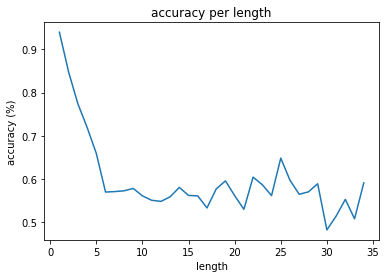

In [37]:
acc = []
for i in range(35):
  correct = accuracy_of_length(predicted_trees_triplets,gold_trees_triplets[:-1],i)
  overall = constituents_of_length(predicted_trees_triplets,i)
  if overall != 0:
      acc.append(correct/overall)
  else:
      acc.append(None)
res = list(filter(lambda x: x[1] != None, enumerate(acc)))
x = [a[0] for a in res]
y = [a[1] for a in res]

import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='length', ylabel='accuracy (%)',
       title='accuracy per length')

plt.show()

<a name="q3.4"></a>
<h3>Question 3.4: Accuracy per Label</h3>

Report accuracy of constituents per label type (S, SBAR, NP, VP, PP etc).
For each node type, report number of occurrences and accuracy. 
Note: report accuracy per node type WITHOUT Chomsky Normal Form modification.
For example, if the CNF of the tree generated a non-terminal NP^S, we should count this as NP for this question.

[Tree('S', [Tree('NP', [Tree('NP', [Tree('NNP', ['Pierre']), Tree('NNP', ['Vinken'])]), Tree('NP|<,-ADJP-,>', [Tree(',', [',']), Tree('NP|<ADJP-,>', [Tree('ADJP', [Tree('NP', [Tree('CD', ['61']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])]), Tree(',', [','])])])]), Tree('S|<VP-.>', [Tree('VP', [Tree('MD', ['will']), Tree('VP', [Tree('VB', ['join']), Tree('VP|<NP-PP-NP>', [Tree('NP', [Tree('DT', ['the']), Tree('NN', ['board'])]), Tree('VP|<PP-NP>', [Tree('PP', [Tree('IN', ['as']), Tree('NP', [Tree('DT', ['a']), Tree('NP|<JJ-NN>', [Tree('JJ', ['nonexecutive']), Tree('NN', ['director'])])])]), Tree('NP', [Tree('NNP', ['Nov.']), Tree('CD', ['29'])])])])])]), Tree('.', ['.'])])])]

In [73]:
def is_original(x):
    return '|' not in x  or  x == 'ADVP|PRT'
def original_label(x):
    if is_original(x):
        return x
    return x.split('|')[0]

# label
NOF_constituents_per_label = defaultdict(lambda : 0)
NOF_correct_constituents_per_label = defaultdict(lambda : 0)

def fill_number_of_constituents_per_label(trees):
    for tree in trees:
        for constituent in tree:
            original = original_label(constituent[0])
            NOF_constituents_per_label[original] += 1
def fill_number_of_correct_constituents_per_label(predicted, gold, labeled=True):
    convert = lambda x: x if  labeled else (x[1],x[2])
    assert(len(predicted) == len(gold))
    for i in range(len(predicted)):
        predicted_tree = predicted[i]
        gold_tree = gold[i]  
        for constituent in predicted_tree:
            original = original_label(constituent[0])
            if any(convert(constituent) == convert(c) for c in gold_tree):
                NOF_correct_constituents_per_label[original] += 1


In [74]:
fill_number_of_constituents_per_label(predicted_trees2)
fill_number_of_correct_constituents_per_label(predicted_trees2,gold_trees2[:-1])


In [80]:
len(NOF_correct_constituents_per_label.keys())

61

In [81]:
len(NOF_constituents_per_label.keys())

61

In [83]:
accuracy_dict = defaultdict(lambda : 0)
for key in NOF_correct_constituents_per_label.keys():
    accuracy_dict[key] = NOF_correct_constituents_per_label[key] / NOF_constituents_per_label[key]

In [95]:
l = [(v, k) for k, v in accuracy_dict.items()]
l.sort(reverse=True)
x = [tup[0] for tup in l]
y = [tup[1] for tup in l]
len(x)

61

(0.0, 1.05)

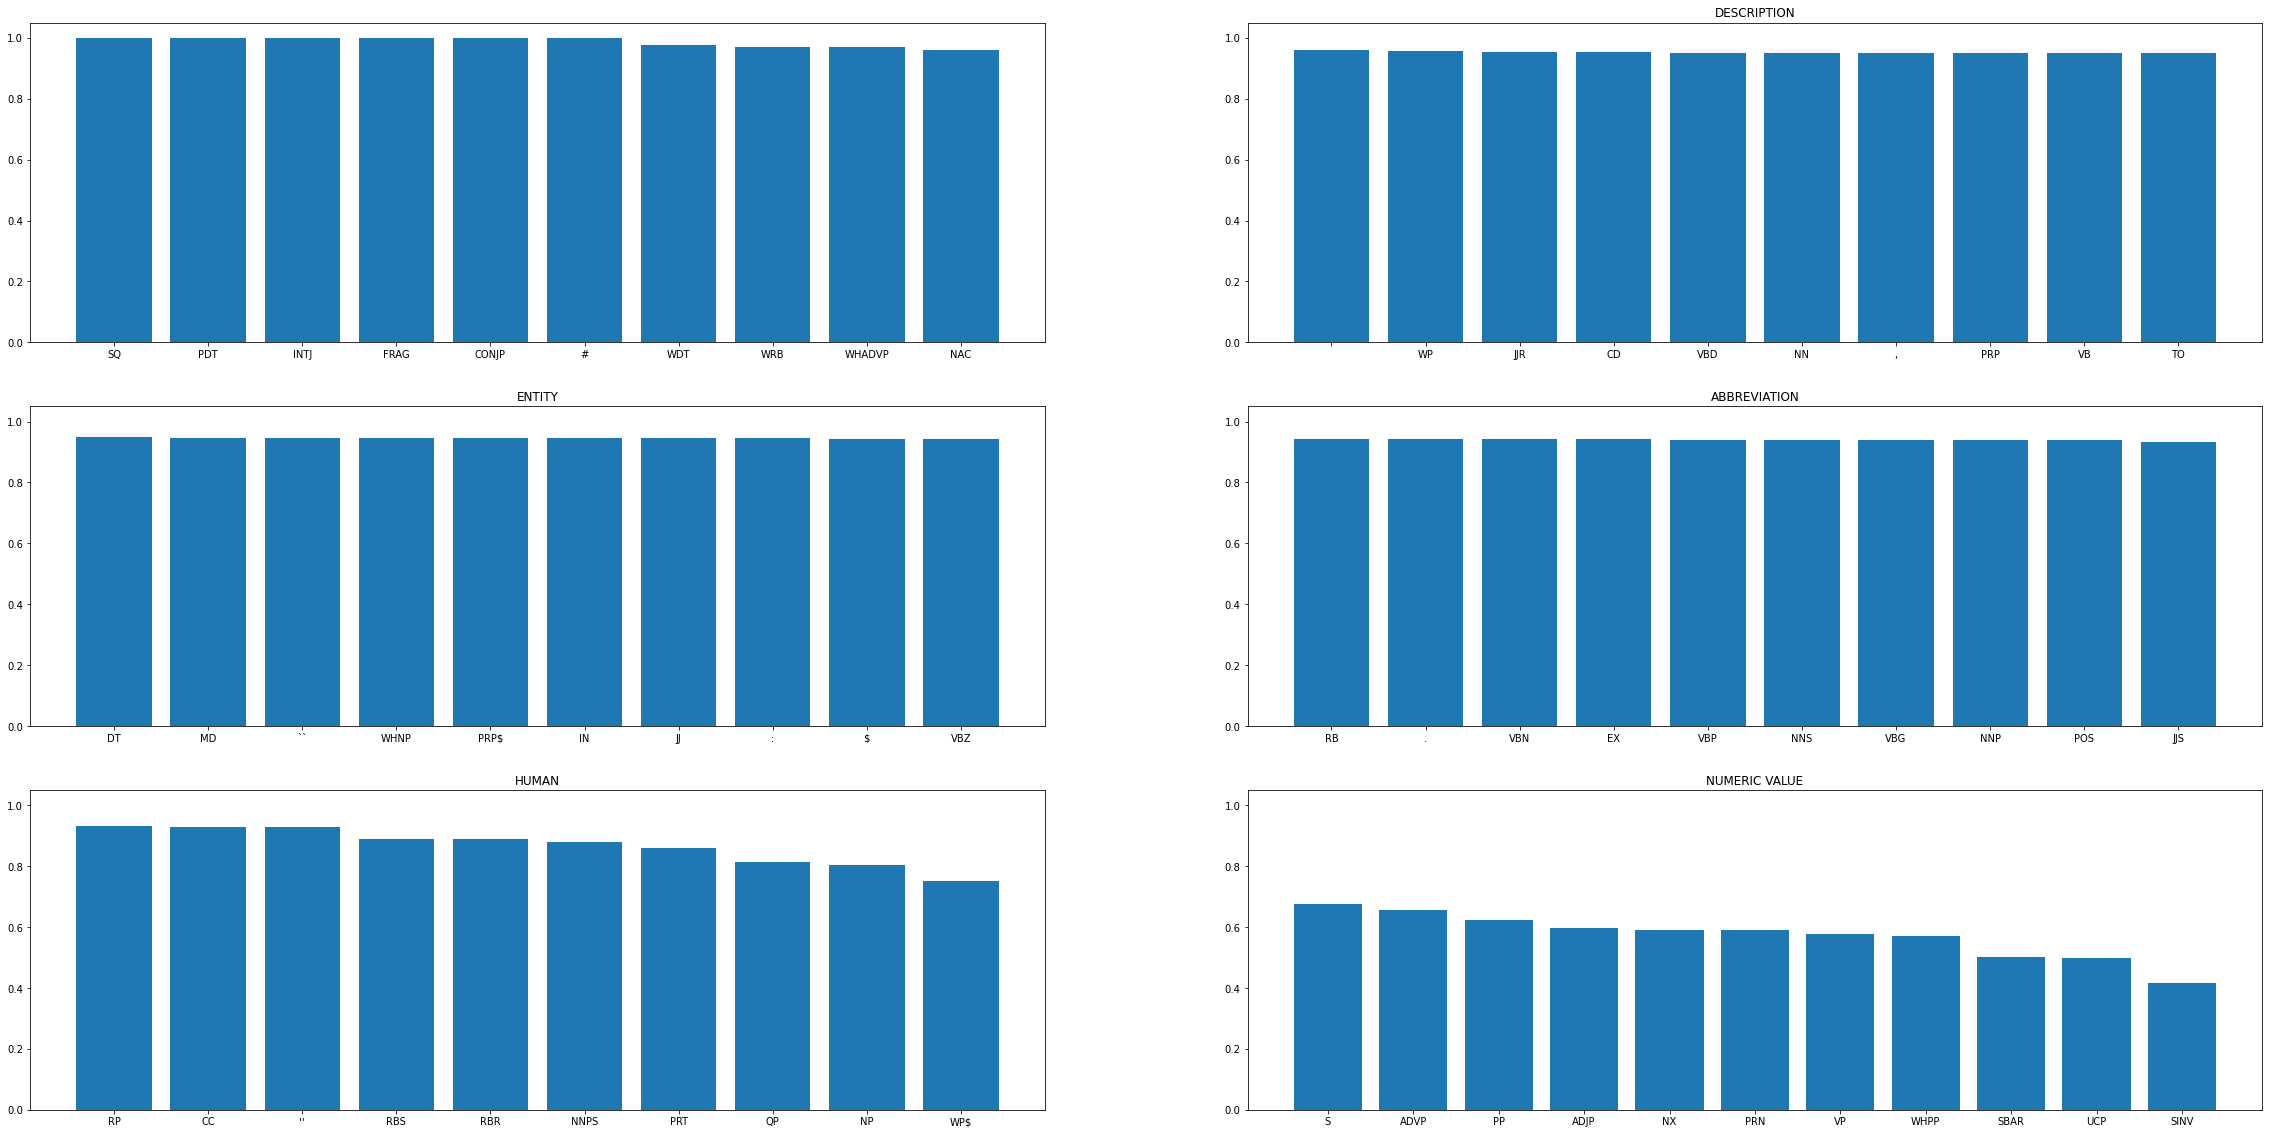

In [105]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline
def count_of(label,coarse=True):
  if coarse:
      return df[df['coarse'] == label].shape[0]
  else:
      return df[df['fine'] == label].shape[0]
def get_percentage_array(coarse=None):
  counts = []
  if coarse == None:
    counts = [count_of(label) for label in coarse_categories]
  else:  
    counts = [count_of(label,coarse=False) for label in fine_categories[coarse]]
  normalized = [count/sum(counts) for count in counts]
  return normalized


# Make square figures and axes
plt.figure(1, figsize=(40,20))
the_grid = GridSpec(3, 2)




plt.subplot(the_grid[0, 0])
plt.bar(y[:10],x[:10])
plt.ylim(top=1.05)
plt.subplot(the_grid[0, 1], title='DESCRIPTION')
plt.bar(y[10:20],x[10:20])
plt.ylim(top=1.05)
plt.subplot(the_grid[1, 0], title='ENTITY')
plt.bar(y[20:30],x[20:30])
plt.ylim(top=1.05)
plt.subplot(the_grid[1, 1], title='ABBREVIATION')
plt.bar(y[30:40],x[30:40])
plt.ylim(top=1.05)
plt.subplot(the_grid[2, 0], title='HUMAN')
plt.bar(y[40:50],x[40:50])
plt.ylim(top=1.05)
plt.subplot(the_grid[2, 1], title='NUMERIC VALUE')
plt.bar(y[50:],x[50:])
plt.ylim(top=1.05)

END